
# Set up the notebook

In [1]:

%pprint

Pretty printing has been turned OFF


In [2]:

import sys

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

from stats_scraping_utils import StatsScrapingUtilities
from storage import Storage
import matplotlib.pyplot as plt
import textwrap
import seaborn as sns
import numpy as np
import pandas as pd
import re
from scipy.stats import pearsonr
%matplotlib inline

# Use the following only if you are on a high definition device
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

s = Storage()
ssu = StatsScrapingUtilities(s=s)
all_countries_df = s.load_object('all_countries_df').set_index('country_code', drop=True)


----


# Prepare the Countries scatterplot


## Get the Country Youth Female Literacy Rate data

In [3]:

url = 'https://www.indexmundi.com/facts/indicators/SE.ADT.1524.LT.FE.ZS/rankings'
tables_list = ssu.get_page_tables(url)

[(0, (157, 4))]


In [4]:

literacy_countries_df = tables_list[0].copy()
# print(literacy_countries_df.columns.tolist())
literacy_countries_df.columns = ['literacy_rank', 'country_name', 'literacy_rate', 'survey_year']
for cn in ['literacy_rate']:
    literacy_countries_df[cn] = literacy_countries_df[cn].map(lambda x: re.sub(r'[^0-9\.]+', '', str(x)))
    literacy_countries_df[cn] = pd.to_numeric(literacy_countries_df[cn], errors='coerce', downcast='float')
literacy_countries_df.head(5)

,literacy_rank,country_name,literacy_rate,survey_year
0,1,Korea,100.000000,2008
1,2,Uzbekistan,100.000000,2019
2,3,Dem. People's Rep. Korea,100.000000,2008
3,4,Serbia,100.000000,2019
4,5,Ukraine,99.980003,2012


In [5]:

# Remove country duplicates and misspellings
literacy_countries_df.country_name = literacy_countries_df.country_name.map(lambda x: ssu.country_name_dict.get(x, x))
countries_list = sorted(set(literacy_countries_df.country_name).symmetric_difference(set(all_countries_df.country_name)))
if countries_list:
    print(countries_list)
doubles_df = ssu.check_4_doubles(countries_list)
mask_series = (doubles_df.max_similarity > 0.6)
if doubles_df[mask_series].shape[0]:
    columns_list = ['first_item', 'second_item', 'max_similarity']
    display(doubles_df[mask_series][columns_list].sort_values('max_similarity', ascending=False))

['American Samoa', 'Andorra', 'Anguilla', 'Antarctica', 'Antigua & Barbuda', 'Aruba', 'Australia', 'Austria', 'Bahamas', 'Belgium', 'Bermuda', 'Bonaire, Sint Eustatius & Saba', 'Bouvet Island', 'British Indian Ocean Territory', 'British Virgin Islands', 'Cabo Verde', 'Canada', 'Christmas Island', 'Cocos (Keeling) Islands', 'Cook Islands', 'Curaçao', 'Czechia', 'Denmark', 'Djibouti', 'Dominica', 'Falkland Islands (Malvinas)', 'Faroe Islands', 'Federated States of Micronesia', 'Fiji', 'Finland', 'France', 'French Guiana', 'French Polynesia', 'French Southern Territories', 'Germany', 'Gibraltar', 'Greenland', 'Guadeloupe', 'Guam', 'Guernsey', 'Heard Island & McDonald Islands', 'Holy See', 'Hong Kong', 'Iceland', 'Ireland', 'Isle of Man', 'Japan', 'Jersey', 'Kiribati', 'Korea', 'Liechtenstein', 'Luxembourg', 'Maldives', 'Marshall Islands', 'Martinique', 'Mayotte', 'Monaco', 'Montserrat', 'Nauru', 'Netherlands', 'New Zealand', 'Niue', 'Norfolk Island', 'Northern Mariana Islands', 'Norway', 

,first_item,second_item,max_similarity
6,Australia,Austria,0.875000
43,Iceland,Ireland,0.857143
14,British Virgin Islands,US Virgin Islands,0.769231
19,Cook Islands,Norfolk Island,0.769231
36,Greenland,Ireland,0.750000
70,Sint Maarten,St. Martin,0.727273
72,Solomon Islands,Åland Islands,0.714286
39,Guernsey,Jersey,0.714286
69,San Marino,St. Martin,0.700000
12,Bouvet Island,Faroe Islands,0.692308


In [6]:

# These countries cause redditors to make hurtful comments *sniff*
country_set = set(all_countries_df.country_name) - set(ssu.derisable_countries_list)
mask_series = literacy_countries_df.country_name.isin(country_set)
literacy_countries_df = literacy_countries_df[mask_series]

mask_series = literacy_countries_df.duplicated(subset=['country_name'], keep=False)
if literacy_countries_df[mask_series].shape[0]:
    display(literacy_countries_df[mask_series].sort_values('country_name'))


## Get the Country Fertility Rate data

In [7]:

if s.pickle_exists('fertility_countries_df'):
    fertility_countries_df = s.load_object('fertility_countries_df')
else:
    tables_list = ssu.get_page_tables('../data/html/world_bank_fertility_rate_by_country.html')
    countries_df = tables_list[0].copy()
    columns_list = ['country_name', 'survey_year', 'fertility_rate']
    countries_df.columns = columns_list
    for cn in ['fertility_rate']:
        countries_df[cn] = countries_df[cn].map(lambda x: re.sub(r'[^0-9\.]+', '', str(x).split(' ')[0]))
        countries_df[cn] = pd.to_numeric(countries_df[cn], errors='coerce', downcast='float')
    mask_series = countries_df.country_name.isnull() | countries_df.fertility_rate.isnull()
    countries_df = countries_df[~mask_series][columns_list]
    s.store_objects(fertility_countries_df=countries_df)

In [ ]:

# Remove country duplicates and misspellings
fertility_countries_df.country_name = fertility_countries_df.country_name.map(lambda x: ssu.country_name_dict.get(x, x))
countries_list = sorted(set(fertility_countries_df.country_name).symmetric_difference(set(all_countries_df.country_name)))
if countries_list:
    print(countries_list)
doubles_df = ssu.check_4_doubles(countries_list)
mask_series = (doubles_df.max_similarity > 0.6)
if doubles_df[mask_series].shape[0]:
    columns_list = ['first_item', 'second_item', 'max_similarity']
    display(doubles_df[mask_series][columns_list].sort_values('max_similarity', ascending=False))

In [12]:

# These countries cause redditors to make hurtful comments *sniff*
country_set = set(all_countries_df.country_name) - set(ssu.derisable_countries_list)
mask_series = fertility_countries_df.country_name.isin(country_set)
fertility_countries_df = fertility_countries_df[mask_series]

mask_series = fertility_countries_df.duplicated(subset=['country_name'], keep=False)
if fertility_countries_df[mask_series].shape[0]:
    display(fertility_countries_df[mask_series].sort_values('country_name'))


## Create the Country scatterplot

In [8]:

# Explanatory variable
xname = 'literacy_rate'

# Response variable
yname = 'fertility_rate'

# Remove NaNs
columns_list = ['country_name', xname, yname]
df = literacy_countries_df.merge(fertility_countries_df, on='country_name', how='inner')[columns_list].dropna()
xdata = df[xname]
ydata = df[yname]

In [9]:

df.sample(5)

,country_name,literacy_rate,fertility_rate
37,Kuwait,99.580002,2.1
7,Azerbaijan,99.910004,1.7
39,Tonga,99.540001,3.5
99,Zimbabwe,93.190002,3.5
48,Libya,99.400002,2.2


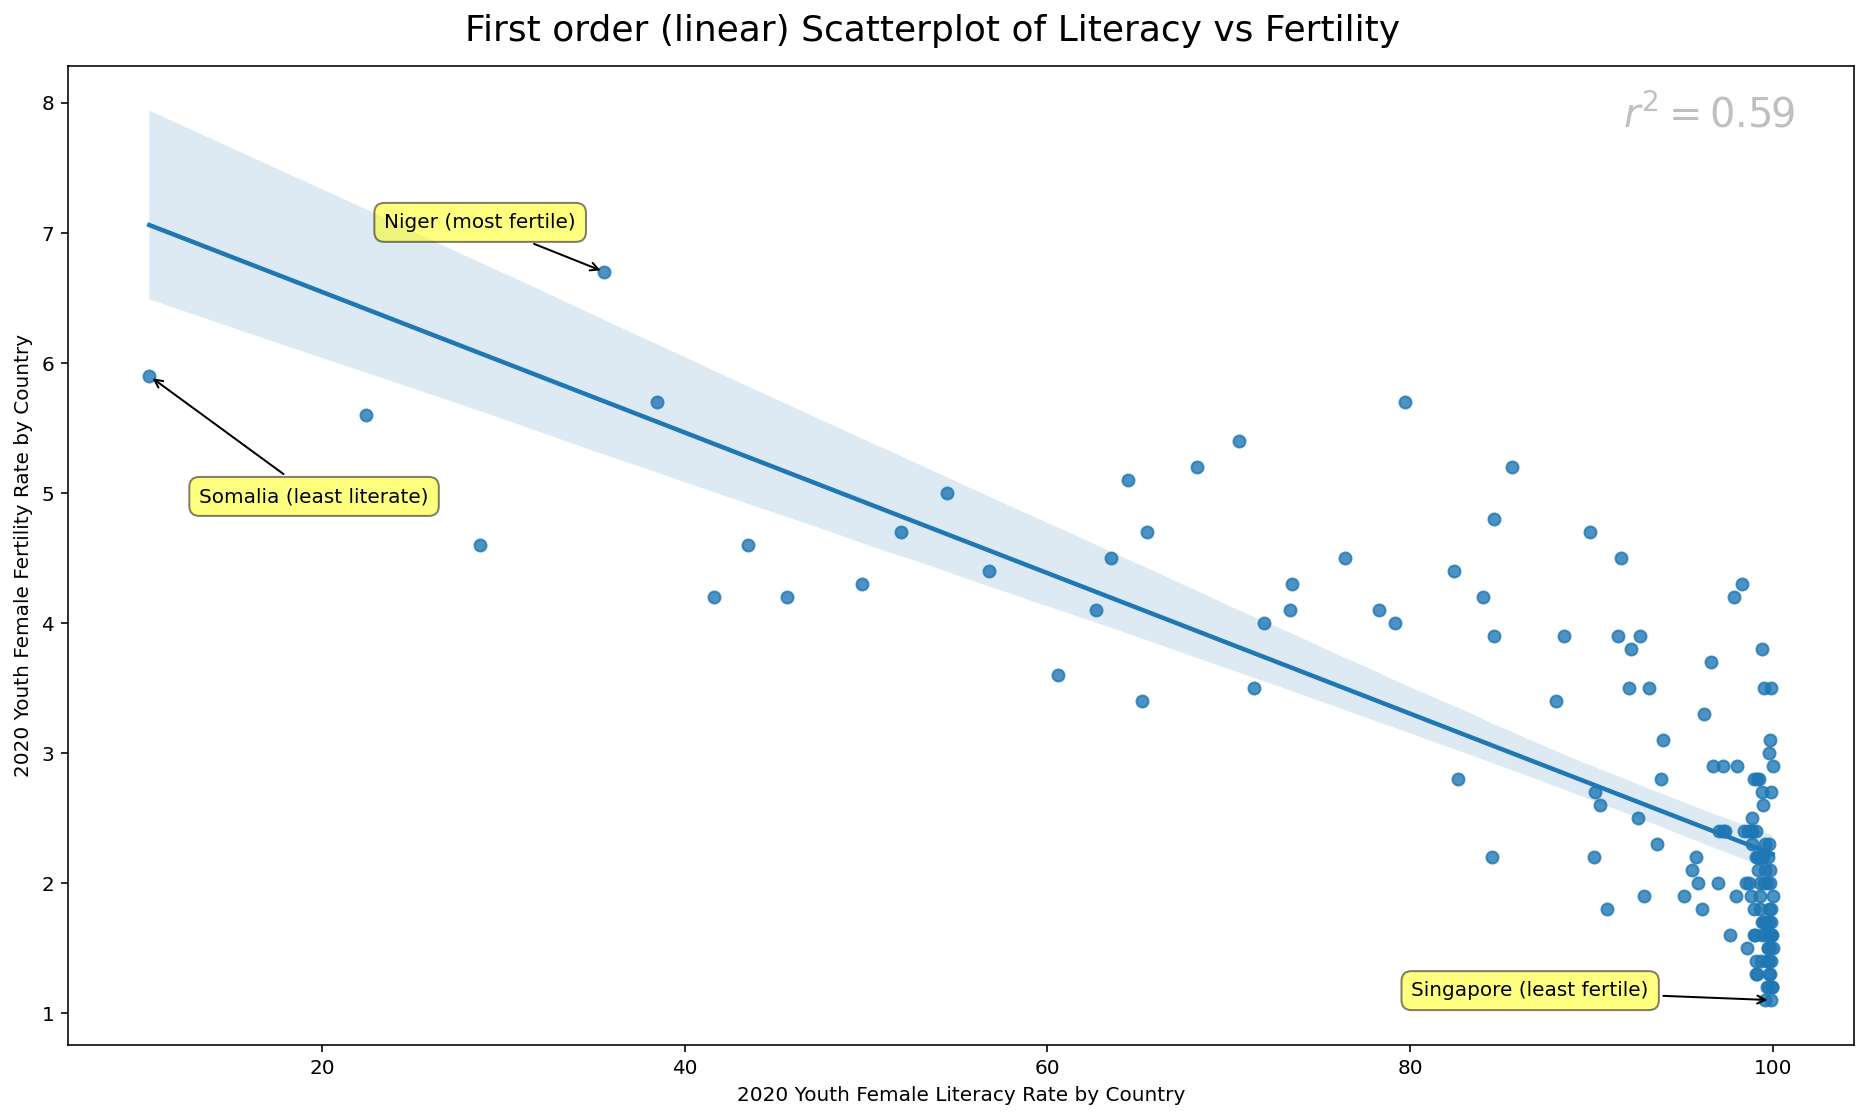

In [24]:

# First order (linear) scatterplot
fig = plt.figure(figsize=(16, 9))
merge_axes_subplot = sns.regplot(x=xname, y=yname, scatter=True, data=df)
xlabel_str = '2020 Youth Female Literacy Rate by Country'
xlabel_text = plt.xlabel(xlabel_str)
ylabel_str = '2020 Youth Female Fertility Rate by Country'
ylabel_text = plt.ylabel(ylabel_str)
kwargs = dict(textcoords='offset points', ha='left', va='bottom',
              bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
least_literate = xdata.min()
most_literate = xdata.max()
most_fertile = ydata.max()
least_fertile = ydata.min()
already_annotated = False
for label, x, y in zip(df['country_name'], xdata, ydata):
    if (x == least_literate):
        annotation = plt.annotate('{} (least literate)'.format(label),
                                  xy=(x, y), xytext=(25, -65), **kwargs)
    elif (y == most_fertile):
        annotation = plt.annotate('{} (most fertile)'.format(label),
                                  xy=(x, y), xytext=(-110, 20), **kwargs)
    elif (y == least_fertile) and not already_annotated:
        already_annotated = True
        annotation = plt.annotate('{} (least fertile)'.format(label),
                                  xy=(x, y), xytext=(-180, 0), **kwargs)

# Add r-squared
plt.text(96.5, 7.9, r'$r^2 = {0:.2}$'.format(pearsonr(xdata, ydata)[0] ** 2), fontsize=20, alpha=0.25,
         horizontalalignment='center', verticalalignment='center')

title_str = 'First order (linear) Scatterplot of Literacy vs Fertility'
title_obj = fig.suptitle(title_str, fontsize=18, y=0.92)